---
title: Second Year Scholarship Data Visualization

format: 
    html: 
        embed-resources: true
        toc: true
        code-fold: true
---

In [215]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import altair as alt

# Introduction: 

The following webpage takes a deep dive into the Aid Worker Security Database, which describes violence against aid workers across the globe. The code describes violence against aid workers from different organizations based on attack type and context, country, organization, whether workers were national or international, and, most importantly for this page, gender. 

The following analysis looks to guide you through the distribution of attacks across the globe, and demonstrate that female aid workers are in significantly more danger than their male counterparts. 

Lets first take a look at the different variables included in the dataset. The dashboards below show the geographic distribution of these variables. 

In [216]:
# Step 1: Load your data
df = pd.read_csv("data/security_incidents.csv")

# Group by country for different categories (Nationals, Internationals, and Incidents)
nationals = df.groupby('Country')['Total nationals'].sum().reset_index(name="total_nationals")
internationals = df.groupby('Country')['Total internationals'].sum().reset_index(name="total_internationals")
incidents_by_country = df.groupby('Country').size().reset_index(name='incident_count')

# Load GeoJSON data for world countries using GeoPandas
geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge the datasets with the GeoDataFrame
geo_data = geo_data.merge(nationals, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(internationals, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(incidents_by_country, left_on="ADMIN", right_on="Country", how="left")



## National vs. International

In [217]:

# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for Nationals
fig.add_trace(go.Choropleth(
    z=geo_data['total_nationals'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='RdYlGn_r',
    colorbar_title="Nationals Affected",
    showscale=True,
    name="Nationals"
))

# Add choropleth for Internationals
fig.add_trace(go.Choropleth(
    z=geo_data['total_internationals'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='YlOrRd',
    colorbar_title="Internationals Affected",
    showscale=True,
    name="Internationals"
))

# Add choropleth for Incidents
fig.add_trace(go.Choropleth(
    z=geo_data['incident_count'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='BuGn',
    colorbar_title="Incidents Count",
    showscale=True,
    name="Incidents"
))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [{'visible': [True, False, False]}, {'title': 'Nationals Affected'}],
                    'label': 'Nationals',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, True, False]}, {'title': 'Internationals Affected'}],
                    'label': 'Internationals',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, False, True]}, {'title': 'Incidents Count'}],
                    'label': 'Incidents',
                    'method': 'update'
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Incidents by Country"
)

fig.write_html("choropleth_map_with_dropdown.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown.html", width=800, height=600)


We can see from above that mainly nationals are targetted, and a majority of incidents take place across Northern Africa and the Middle East. This is most likely due to the distribution of nationals vs. international aid workers stationed across the countries, with national aid workers being in much higher numbers. 

## Means of Attack

In [218]:
unique_values = df['Means of attack'].unique()
means_of_attack = df.groupby(['Country', 'Means of attack']).size().unstack(fill_value=0)

geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

for incident in unique_values:
    # Ensure the column name is consistent (spaces replaced with underscores and lowercased)
    incident_column = f'{incident.replace(" ", "_").lower()}_count'
    
    # Check if the incident type is present in the incident_counts DataFrame
    if incident in means_of_attack.columns:
        # Add the incident counts from the incident_counts DataFrame
        geo_data = geo_data.merge(
            means_of_attack[incident], left_on="ADMIN", right_index=True, how="left"
        ).rename(columns={incident: incident_column})
    else:
        # If the incident type is not in the incident_counts DataFrame, fill with 0
        geo_data[incident_column] = 0
# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for each incident type
for incident in unique_values:
    # Update the z values and title dynamically for each incident
    # Calculate the total value for the column
    total_value = geo_data[f'{incident.replace(" ", "_").lower()}_count'].sum()
    
    # Calculate the percentage for each country
    geo_data[f'{incident}_percentage'] = (geo_data[f'{incident.replace(" ", "_").lower()}_count'] / total_value) * 100
    
    fig.add_trace(go.Choropleth(
        z=geo_data[f'{incident.replace(" ", "_").lower()}_count'],  # Assuming you have these fields in your geo_data
        hoverinfo='location+z',
        locations=geo_data['ADMIN'],  # Country names should be in the 'ADMIN' field
        locationmode='country names',
        colorscale='Viridis',  # You can change the color scale for each incident type if you like
        colorbar_title=f"{incident} Count",
        showscale=True,
        name=incident,
        text=geo_data[f'{incident}_percentage'].apply(lambda x: f"{x:.2f}%")
    ))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                # Create a button for each incident type to switch between
                *[
                    {
                        'args': [{'visible': [i == idx for i in range(len(unique_values))]}, {'title': f'{incident} Count'}],
                        'label': incident,
                        'method': 'update'
                    }
                    for idx, incident in enumerate(unique_values)
                ]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Incidents by Country"
)

fig.write_html("choropleth_map_with_dropdown2.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown2.html", width=800, height=600)


We look at the means of attack above across all countries that have incidents. Aid organizations often struggle with reporting (as this is not their first priority), so many of the attacks are of unknown means. 

## Organization

In [219]:
un = df.groupby('Country')['UN'].sum().reset_index(name="total_un")
ingo = df.groupby('Country')['INGO'].sum().reset_index(name="total_ingo")
icrc = df.groupby('Country')['ICRC'].sum().reset_index(name="total_icrc")
nrcs_ifrc = df.groupby('Country')['NRCS and IFRC'].sum().reset_index(name="total_nrcs_ifrc")
nngo = df.groupby('Country')['NNGO'].sum().reset_index(name="total_nngo")
other = df.groupby('Country')['Other'].sum().reset_index(name="total_other")
ingo = ingo.rename(columns={'Country': 'Country_ingo'})
nngo = nngo.rename(columns={'Country': 'Country_nngo'})
other = other.rename(columns={'Country': 'Country_other'})



geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')


geo_data = geo_data.merge(un, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(ingo, left_on="ADMIN", right_on="Country_ingo", how="left")
geo_data = geo_data.merge(icrc, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(nrcs_ifrc, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(nngo, left_on="ADMIN", right_on="Country_nngo", how="left")
geo_data = geo_data.merge(other, left_on="ADMIN", right_on="Country_other", how="left")

# List of the categories for the dropdown
columns = ['UN', 'INGO', 'ICRC', 'NRCS and IFRC', 'NNGO', 'Other']
fig = go.Figure()

# Add choropleth for each column (UN, INGO, ICRC, etc.)
for column in columns:
    # Get the appropriate column name for the data
    if column == 'NRCS and IFRC':
        field_name = 'total_nrcs_ifrc'
    else:
        field_name = f'total_{column.lower()}'
    
    # Calculate the total value for the column
    total_value = geo_data[field_name].sum()
    
    # Calculate the percentage for each country
    geo_data[f'{field_name}_percentage'] = (geo_data[field_name] / total_value) * 100

    # Add the choropleth trace for the current column
    fig.add_trace(go.Choropleth(
        z=geo_data[field_name],  # Value for the choropleth (total number)
        hoverinfo='location+z+text',  # Add text info to hover
        locations=geo_data['ADMIN'],  # Country names should be in the 'ADMIN' field
        locationmode='country names',
        colorscale='Viridis',  # You can change the color scale for each category if you like
        colorbar_title=f"{column} Count",
        showscale=True,
        name=column,
        text=geo_data[f'{field_name}_percentage'].apply(lambda x: f"{x:.2f}%")  # Add percentage to hover text
    ))
    
# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                # Create a button for each category to switch between
                *[
                    {
                        'args': [{'visible': [i == idx for i in range(len(columns))]}, {'title': f'{column} Count'}],
                        'label': column,
                        'method': 'update'
                    }
                    for idx, column in enumerate(columns)
                ]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Counts by Country"
)

# Save the figure to an HTML file
fig.write_html("choropleth_map_with_dropdown.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown.html", width=800, height=600)

# Gender Distribution of Incidents

In [ ]:
females = df.groupby('Country')['Gender Male'].sum().reset_index(name="male_total")
males = df.groupby('Country')['Gender Female'].sum().reset_index(name="female_total")

# Load GeoJSON data for world countries using GeoPandas
geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge the datasets with the GeoDataFrame
geo_data = geo_data.merge(females, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(males, left_on="ADMIN", right_on="Country", how="left")

# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for Nationals
fig.add_trace(go.Choropleth(
    z=geo_data['male_total'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='RdYlGn_r',
    colorbar_title="Total Males",
    showscale=True,
    name="Males"
))

# Add choropleth for Internationals
fig.add_trace(go.Choropleth(
    z=geo_data['female_total'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='YlOrRd',
    colorbar_title="Total Females",
    showscale=True,
    name="Females"
))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [{'visible': [True, False, False]}, {'title': 'Males Affected'}],
                    'label': 'Males',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, True, False]}, {'title': 'Females Affected'}],
                    'label': 'Females',
                    'method': 'update'
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Gender Distribution"
)

fig.write_html("choropleth_map_with_dropdown3.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown3.html", width=800, height=600)

/var/folders/8n/rfnmqbtd0tvdljpw_xbt64jh0000gn/T/ipykernel_86281/2091133605.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



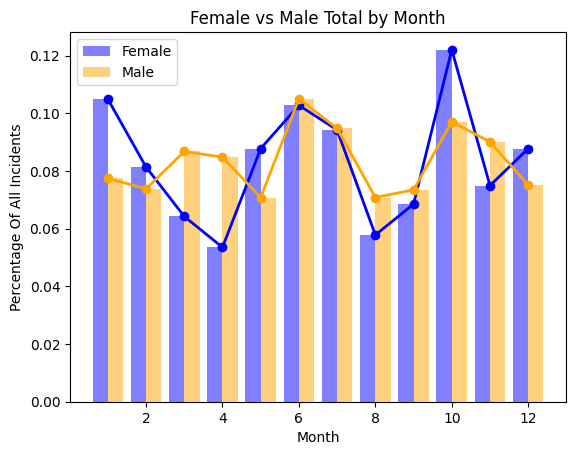

In [242]:
import matplotlib.pyplot as plt

df_clean = df.dropna()
df_clean['Date'] = pd.to_datetime(df_clean['Year'].astype(str) + '-' + df_clean['Month'].astype(int).astype(str) + '-01', format='%Y-%m-%d')
df_clean.head()

male = df_clean.groupby('Month')['Gender Male'].sum().reset_index(name="total_male")
female = df_clean.groupby('Month')['Gender Female'].sum().reset_index(name="total_female")

plt.bar(female["Month"] - 0.2, female["total_female"] / female["total_female"].sum(), width=0.4, label="Female", color='blue', align='center', alpha = .5)  # Female bars
plt.bar(male["Month"] + 0.2, male["total_male"] / male["total_male"].sum(), width=0.4, label="Male", color='orange', align='center', alpha = 0.5)  # Male bars
plt.plot(female["Month"], female["total_female"] / female["total_female"].sum(), color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(male["Month"], male["total_male"] / male["total_male"].sum(), color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Percentage Of All Incidents')
plt.title('Female vs Male Total by Month')
plt.legend()
plt.show()





/var/folders/8n/rfnmqbtd0tvdljpw_xbt64jh0000gn/T/ipykernel_86281/4288500049.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



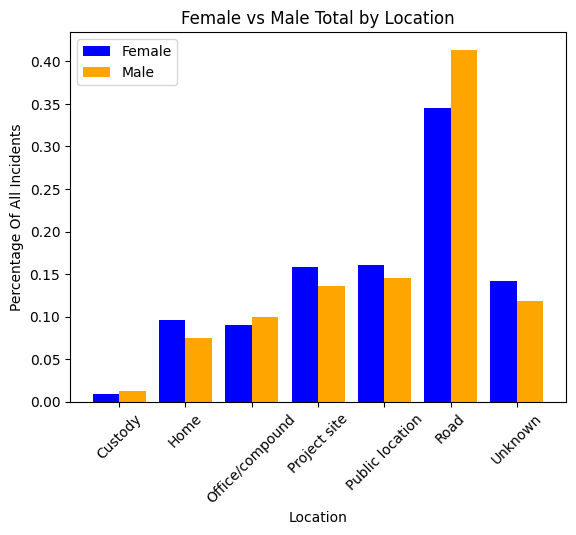

In [252]:
df_clean = df.dropna()
df_clean['Date'] = pd.to_datetime(df_clean['Year'].astype(str) + '-' + df_clean['Month'].astype(int).astype(str) + '-01', format='%Y-%m-%d')
df_clean.head()

male = df_clean.groupby('Location')['Gender Male'].sum().reset_index(name="total_male")
female = df_clean.groupby('Location')['Gender Female'].sum().reset_index(name="total_female")
locations = female["Location"]
x = range(len(locations))  # Create an index for each location

# Adjust the position for the female bars (shifted left)
plt.bar([i - 0.2 for i in x], female["total_female"] / female["total_female"].sum(), width=0.4, label="Female", color='blue', align='center')

# Adjust the position for the male bars (shifted right)
plt.bar([i + 0.2 for i in x], male["total_male"] / male["total_male"].sum(), width=0.4, label="Male", color='orange', align='center')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage Of All Incidents')
plt.title('Female vs Male Total by Location')
plt.xticks([i for i in x], locations, rotation = 45)
plt.legend()
plt.show()

In [261]:
male = df_clean.groupby(['Location', 'Motive'])['Gender Male'].sum().reset_index(name="total_male")
female = df_clean.groupby(['Location', 'Motive'])['Gender Female'].sum().reset_index(name="total_female")
male["total_male"] = male["total_male"] / male["total_male"].sum()
female["total_female"] = female["total_female"] / female["total_female"].sum()

male_chart = alt.Chart(male).mark_rect().encode(
    alt.X('Motive:N').title('Motive'),
    alt.Y('Location:N').title('Location'),
    alt.Color('total_male:Q').title('Males Involved in Incidents')
).properties(
    title='Male Involvement in Incidents'
)

# Female chart
female_chart = alt.Chart(female).mark_rect().encode(
    alt.X('Motive:N').title('Motive'),
    alt.Y('Location:N').title('Location'),
    alt.Color('total_female:Q').title('Females Involved in Incidents')
).properties(
    title='Female Involvement in Incidents'
)

# Combine both charts using facet
male_female_chart = alt.hconcat(
    male_chart,
    female_chart
)

male_female_chart

alt.HConcatChart(...)